In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [85]:
predictions_dict = {}

In [86]:
config_filename = 'weights.yaml'
config = read_config(config_filename)

In [87]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
pulling from cache
loading from ../../misc/cache/dataframes_ts_14102020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 162                 | 163                 | 164                 | 165                 | 166                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-06 00:00:00 | 2020-10-07 00:00:00 | 2020-10-08 00:00:00 | 2020-10-09 00:00:00 | 2020-10-10 00:00:00 |
| state       | Jharkhand           | Jharkhand           | Jharkhand           | Jharkhand           | Jharkhand           |
| district    | Ranchi              | Ranchi              | Ranchi              | Ranchi              | Ranchi              |
| total       | 21043.14            | 21356.29            | 21511.17            | 21664.2       

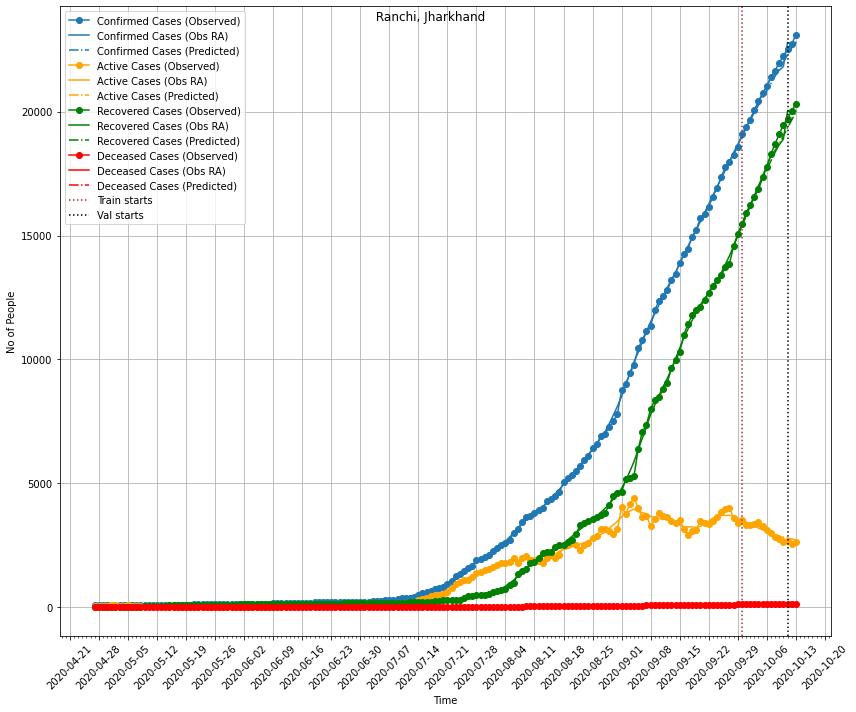

In [88]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 10
m2_params['split']['test_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)
# predictions_dict['m2'] = predictions_dict['m1']

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [89]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.3574379770906384,
 'I_hosp_ratio': 0.32236468733020457,
 'P_fatal': 0.018928585594445456,
 'T_inc': 4.867552560064436,
 'T_inf': 3.2647002031018224,
 'T_recov': 8.415039545208714,
 'T_recov_fatal': 28.78785646945747,
 'lockdown_R0': 0.97682594787569}

In [90]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.3574379770906384,
 'I_hosp_ratio': 0.32236468733020457,
 'P_fatal': 0.018928585594445456,
 'T_inc': 4.867552560064436,
 'T_inf': 3.2647002031018224,
 'T_recov': 8.415039545208714,
 'T_recov_fatal': 28.78785646945747,
 'lockdown_R0': 0.97682594787569}

## Loss Dataframes

### M1 Loss DataFrame

In [91]:
predictions_dict['m1']['df_loss']

train       val
total      0.764495  0.968333
active       3.3866    5.3092
recovered  0.973568   1.80436
deceased    1.88248   1.35798

### M2 Loss DataFrame

In [92]:
predictions_dict['m2']['df_loss']

train       val
total      0.764495  0.968333
active       3.3866    5.3092
recovered  0.973568   1.80436
deceased    1.88248   1.35798

## Sensitivity Plot

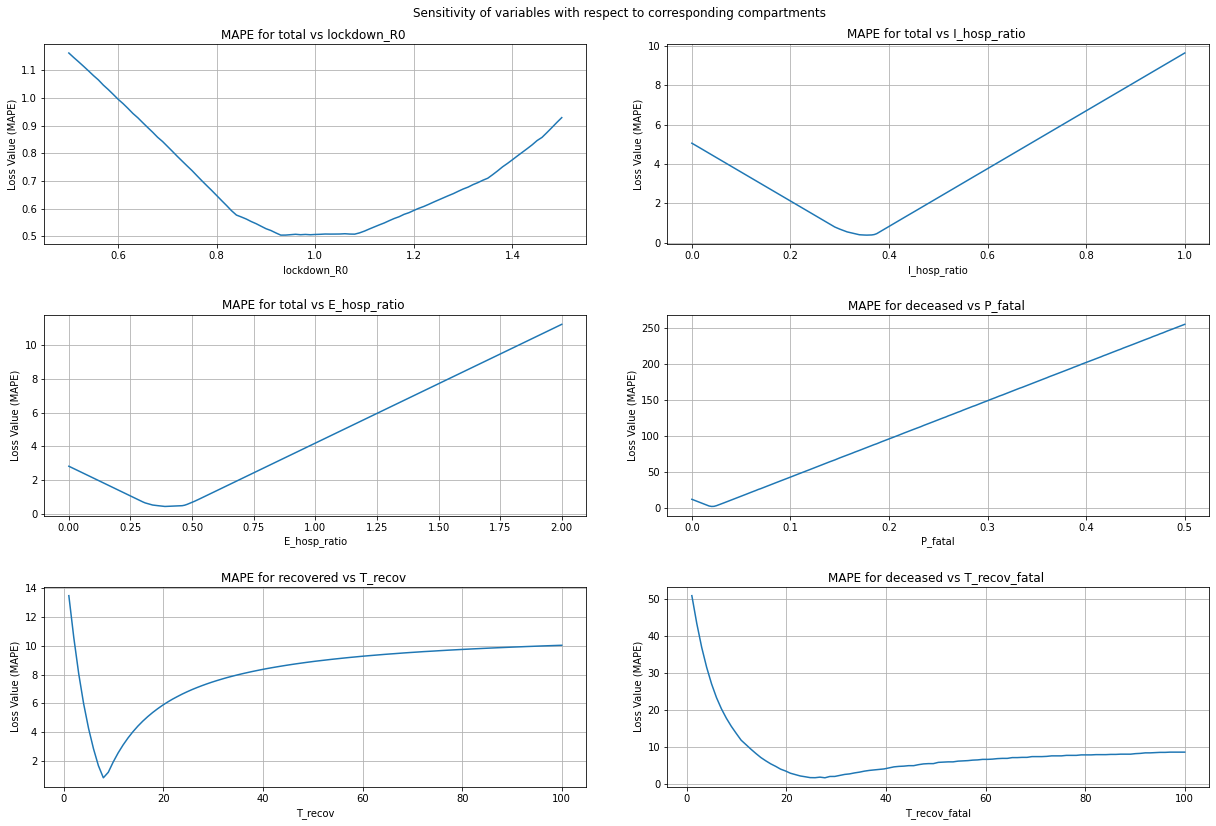

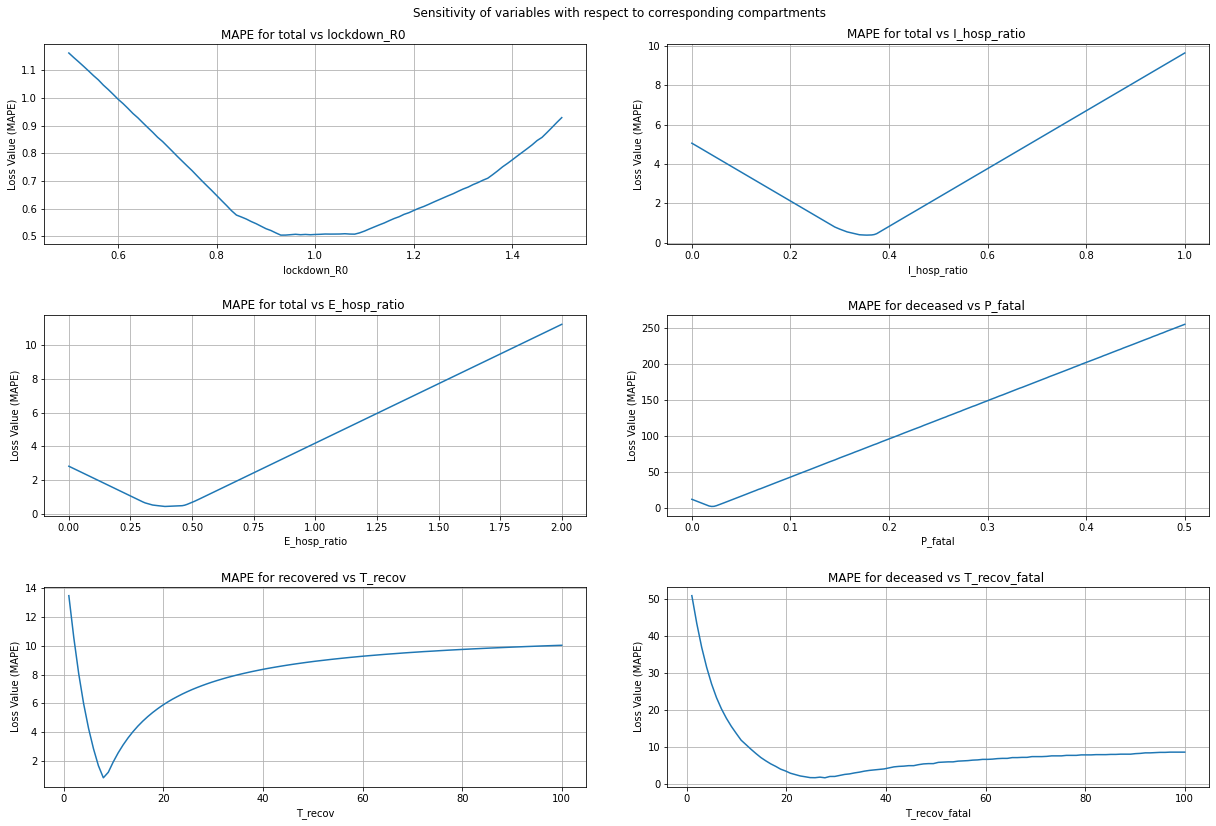

In [93]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [94]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


[         date        S     E     I  R_recov  R_fatal      C    D  active  \
0  2020-09-30  3278611  1253  1130     3440       66  15382  114    3506   
1  2020-10-01  3278286  1314  1060     3364       70  15786  116    3434   
2  2020-10-02  3277978  1348  1016     3281       73  16181  119    3354   
3  2020-10-03  3277681  1366   988     3197       77  16566  122    3274   
4  2020-10-04  3277389  1376   970     3116       79  16941  124    3195   
5  2020-10-05  3277103  1379   958     3040       82  17307  127    3122   
6  2020-10-06  3276820  1379   949     2970       85  17664  130    3055   
7  2020-10-07  3276538  1377   943     2905       87  18013  133    2992   
8  2020-10-08  3276259  1374   937     2846       90  18355  136    2936   
9  2020-10-09  3275981  1370   933     2792       92  18690  139    2884   
10 2020-10-10  3275705  1365   928     2743       94  19019  143    2837   
11 2020-10-11  3275429  1360   925     2698       96  19342  146    2794   
12 2020-10-

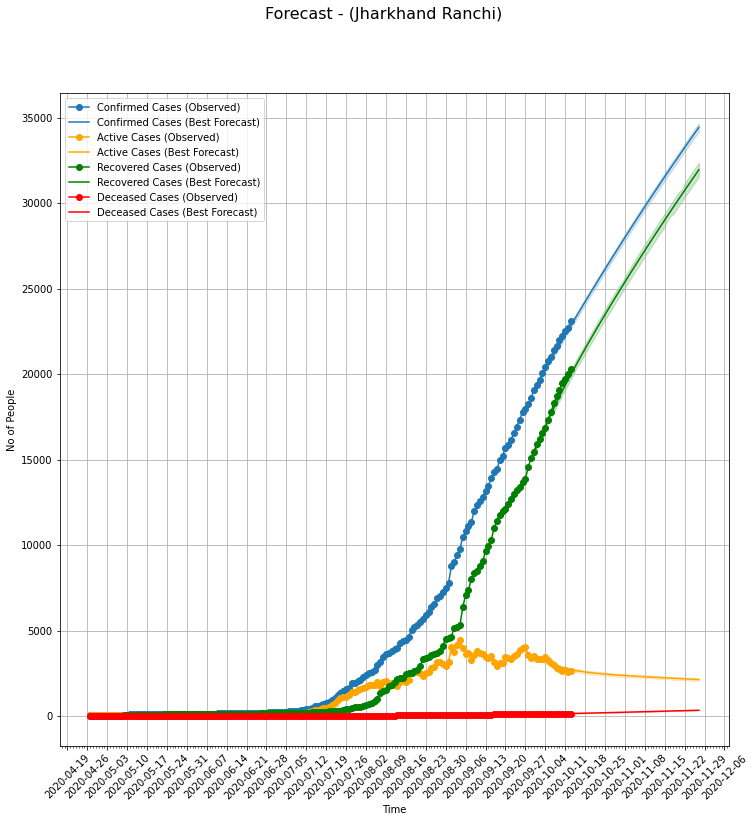

In [95]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [96]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

13it [00:00, 126.37it/s]getting forecasts ..
1000it [00:09, 102.43it/s]


In [97]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

11it [00:00, 106.28it/s]getting forecasts ..
1000it [00:10, 99.82it/s]


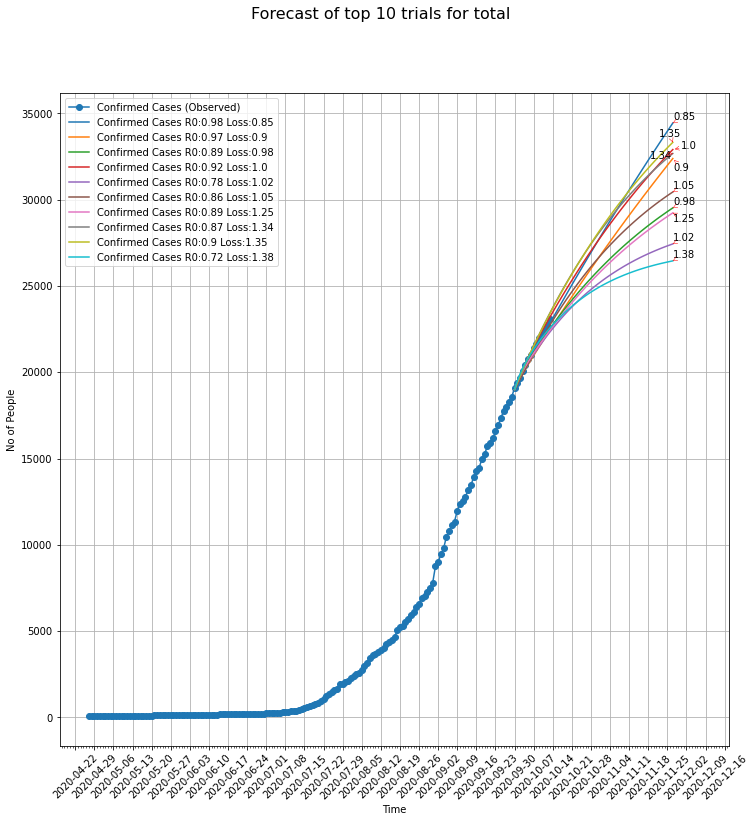

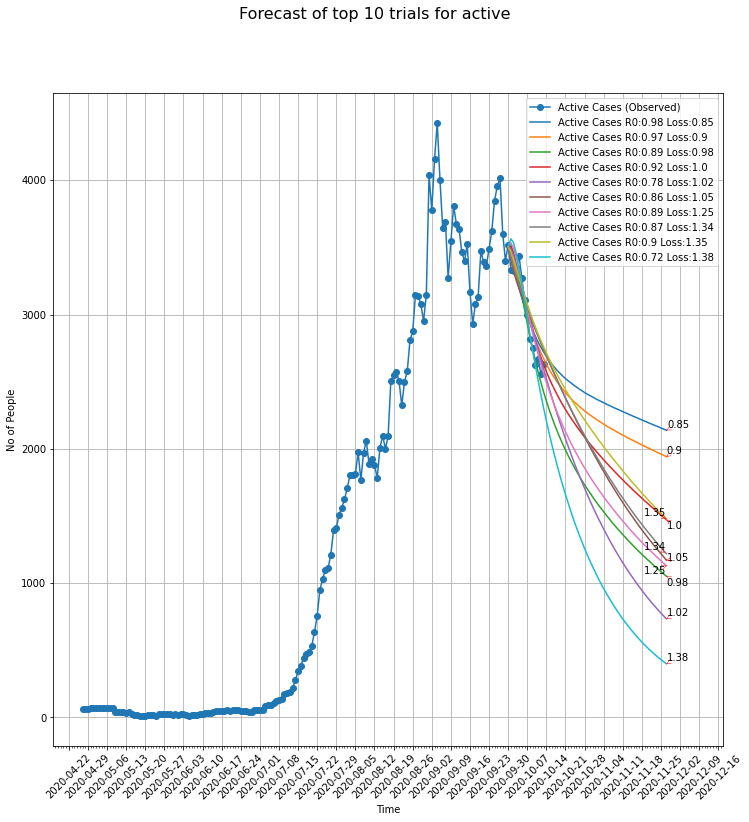

In [98]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [99]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [100]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:50<00:00,  1.96trial/s, best loss: 1.8860548067569645]


In [101]:
uncertainty.beta_loss

{'active': 3.0287748446821943,
 'recovered': 1.63368224833075,
 'deceased': 1.8053686420425772,
 'total': 1.076393491972337}

In [102]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [103]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

20556  
6       17664       130  20849  
7       18013       133  21138  
8       18355       136  21427  
9       18690       139  21713  
10      19019       143  21999  
11      19342       146  22282  
12      19660       149  22565  
13      19974       153  22847  
14      20283       156  23127  
15      20589       160  23407  
16      20891       163  23685  
17      21189       167  23962  
18      21485       171  24239  
19      21778       175  24515  
20      22068       179  24789  
21      22355       182  25060  
22      22641       186  25333  
23      22924       190  25605  
24      23205       194  25874  
25      23485       198  26143  
26      23763       203  26412  
27      24039       207  26679  
28      24313       211  26943  
29      24586       215  27208  
30      24857       219  27472  
31      25127       223  27735  
32      25395       228  27997  
33      25662       232  28257  
34      25928       236  28517  
35      26192       241  28776  
36

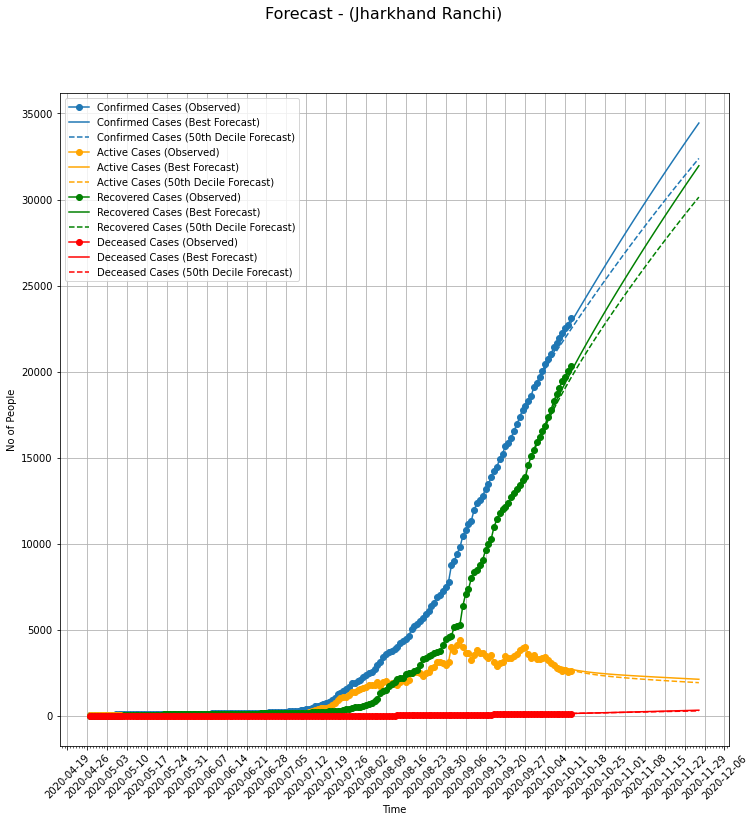

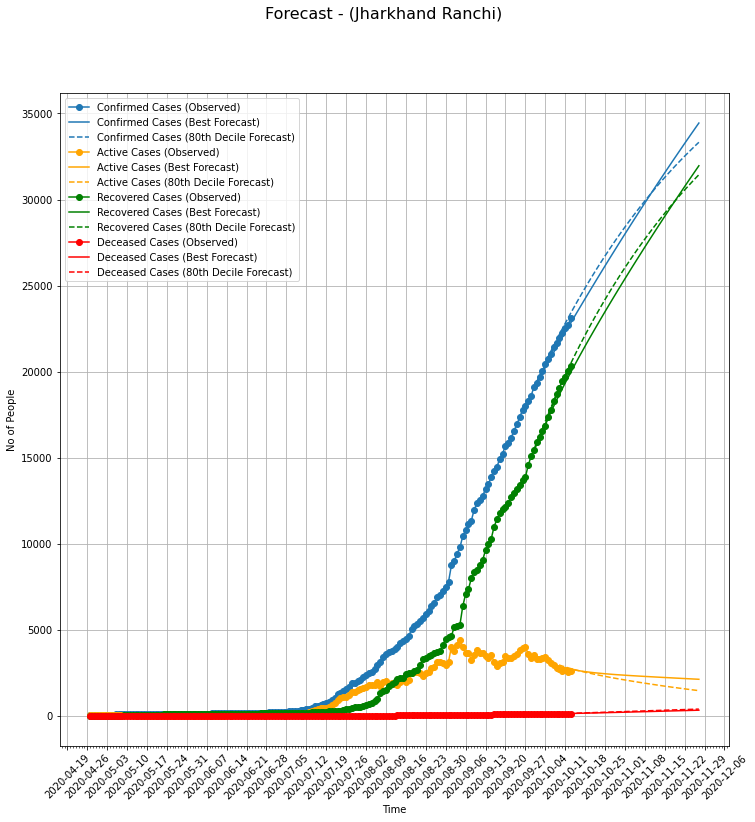

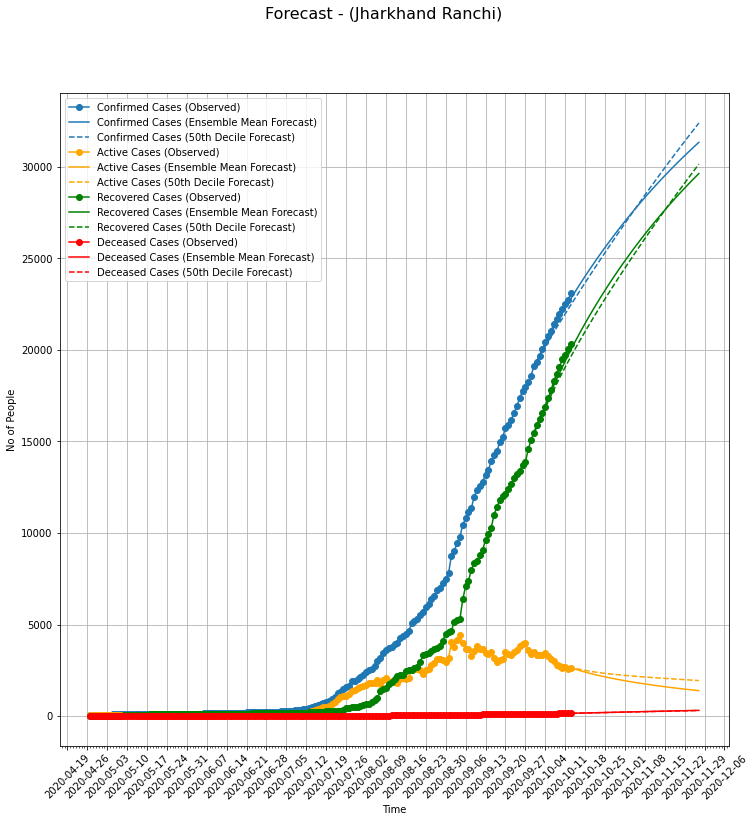

In [104]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

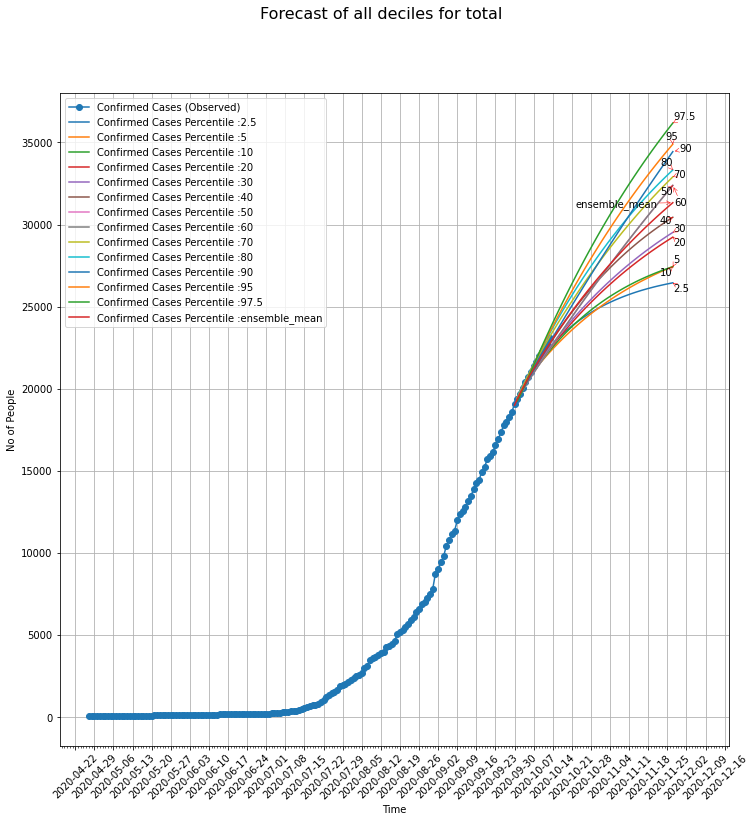

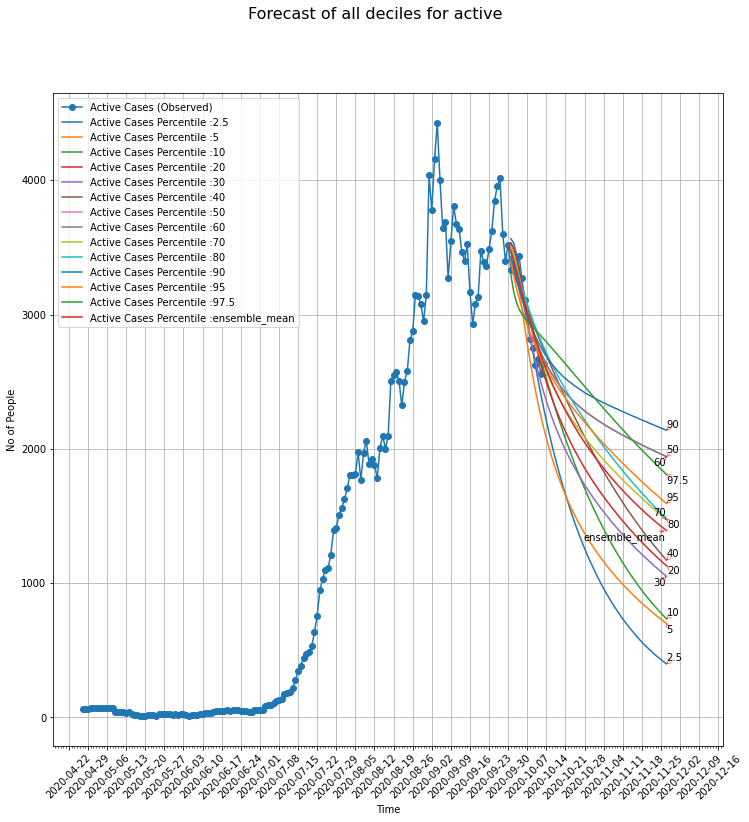

In [105]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


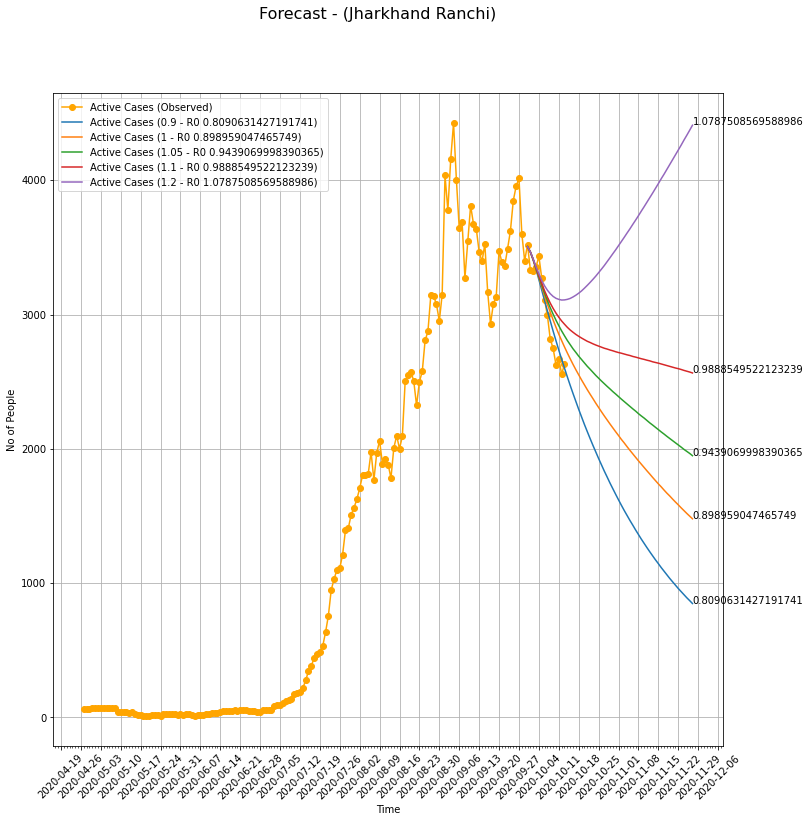

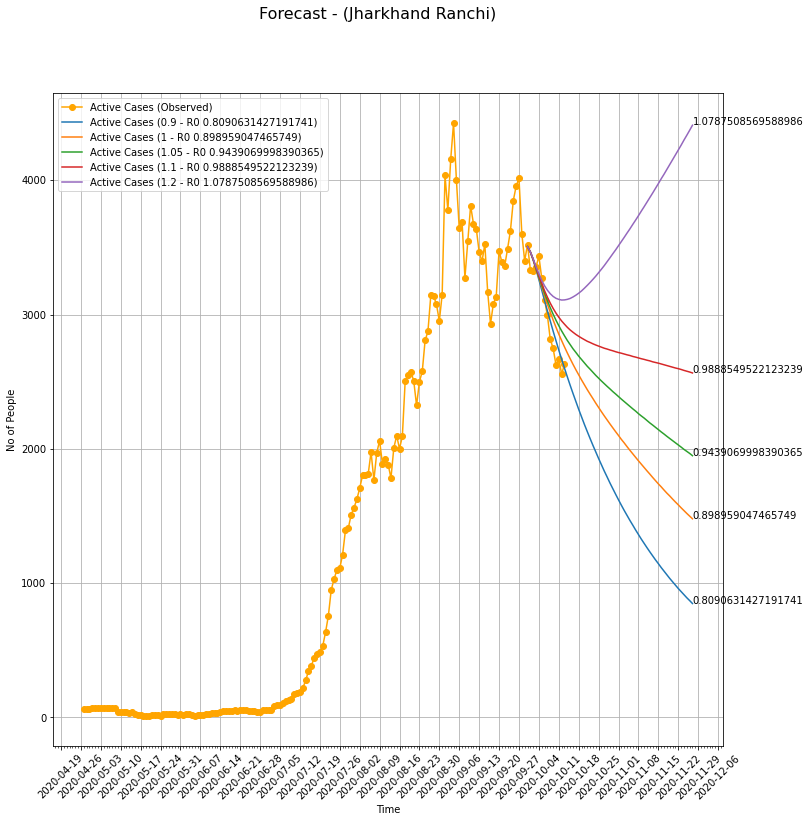

In [106]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_mul_dict = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
plot_r0_multipliers(predictions_dict, None, predictions_mul_dict, None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Create Report

In [107]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [108]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [109]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [110]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Create R0 Multiplier Output

In [111]:
save_r0_mul(predictions_mul_dict, output_folder)

## Create df_district Output

In [112]:
predictions_dict['m1']['df_district'].to_csv(f'{output_folder}/df_district.csv')

## Experiments

In [113]:
predictions_dict['m1'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'df_district_unsmoothed', 'run_params', 'forecasts', 'trials_processed', 'beta', 'beta_loss', 'deciles'])

In [114]:
predictions_dict['m2'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'df_district_unsmoothed', 'run_params', 'forecasts', 'trials_processed', 'beta', 'beta_loss', 'deciles'])

In [115]:
predictions_dict['m2']['df_district']

date      state district  total  active  recovered  deceased  \
0   2020-04-27  Jharkhand   Ranchi     75      63         10         2   
1   2020-04-28  Jharkhand   Ranchi     77      65         10         2   
2   2020-04-29  Jharkhand   Ranchi     78      66         10         2   
3   2020-04-30  Jharkhand   Ranchi     81      69         10         2   
4   2020-05-01  Jharkhand   Ranchi     83      71         10         2   
..         ...        ...      ...    ...     ...        ...       ...   
165 2020-10-09  Jharkhand   Ranchi  21975    2749      19083       143   
166 2020-10-10  Jharkhand   Ranchi  22245    2627      19474       144   
167 2020-10-11  Jharkhand   Ranchi  22531    2669      19718       144   
168 2020-10-12  Jharkhand   Ranchi  22730    2557      20026       147   
169 2020-10-13  Jharkhand   Ranchi  23094    2628      20315       151   

     tested  other  daily_cases  
0       NaN    NaN         20.0  
1       NaN    NaN          2.0  
2       NaN    NaN          1.0  
3       NaN    NaN          3.0  
4       NaN    NaN          2.0  
..      ...    ...          ...  
165     NaN    NaN        314.0  
166     NaN    NaN        270.0  
167     NaN    NaN        286.0  
168     NaN    NaN        199.0  
169     NaN    NaN        364.0  

[170 rows x 10 columns]

In [116]:
from utils.fitting.data_weights import Data_Weights

In [117]:
weights = config['fitting']['data_weights']['weights']

In [118]:
start_date = config['fitting']['data_weights']['start_date']
end_date = config['fitting']['data_weights']['end_date']

In [119]:
df_district = predictions_dict['m1']['df_district']

In [120]:
df_data_weights = Data_Weights.make_weights_df(0, df_district, start_date, end_date, weights)

          date      state district  total  active  recovered  deceased  \
0   2020-04-27  Jharkhand   Ranchi     75      63         10         2   
1   2020-04-28  Jharkhand   Ranchi     77      65         10         2   
2   2020-04-29  Jharkhand   Ranchi     78      66         10         2   
3   2020-04-30  Jharkhand   Ranchi     81      69         10         2   
4   2020-05-01  Jharkhand   Ranchi     83      71         10         2   
..         ...        ...      ...    ...     ...        ...       ...   
165 2020-10-09  Jharkhand   Ranchi  21975    2749      19083       143   
166 2020-10-10  Jharkhand   Ranchi  22245    2627      19474       144   
167 2020-10-11  Jharkhand   Ranchi  22531    2669      19718       144   
168 2020-10-12  Jharkhand   Ranchi  22730    2557      20026       147   
169 2020-10-13  Jharkhand   Ranchi  23094    2628      20315       151   

     tested  other  daily_cases  
0       NaN    NaN         20.0  
1       NaN    NaN          2.0  
2       N

In [121]:
start_date, end_date, train_period, val_period, test_period = config['fitting']['split'].values()

In [122]:
df_data_weights_train, df_data_weights_val, df_data_weights_test = Data_Weights.implement_split(0, df_data_weights, train_period,val_period, test_period, start_date, end_date)

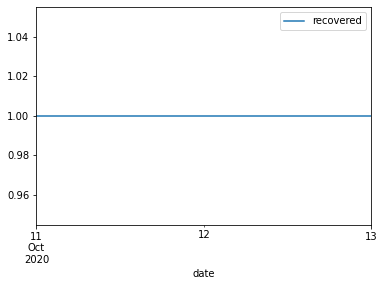

In [123]:
df_data_weights_val.plot(x='date', y='recovered')